## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras. 

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import os

# Configuración de paths y fecha
current_dir = os.getcwd()
data_path = os.path.join(os.path.dirname(current_dir), 'data') if 'src' in current_dir else '../data' if os.path.exists('../data') else 'data'
fecha_analisis = datetime(2025, 10, 1)

### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

In [75]:
universo = pd.read_csv(os.path.join(data_path, 'universo.csv'), sep=';')
universo['Maturity'] = pd.to_datetime(universo['Maturity'], format='%d/%m/%Y', errors='coerce')

# Convertir Next Call Date a datetime si existe
if 'Next Call Date' in universo.columns:
    universo['Next Call Date'] = pd.to_datetime(universo['Next Call Date'], format='%d/%m/%Y', errors='coerce')

# Crear copia explícita para evitar SettingWithCopyWarning
vivos = universo[universo['Maturity'] > fecha_analisis].copy()

# Calcular 'Años a maturity': usar Next Call Date si es callable, sino usar Maturity
def calculate_years_maturity(row):
    """Calcula años hasta maturity, considerando callable bonds"""
    # Si es callable y tiene Next Call Date, usar esa fecha
    if pd.notna(row.get('Callable')) and str(row.get('Callable')).upper() == 'Y':
        if pd.notna(row.get('Next Call Date')):
            eff_maturity = row['Next Call Date']
        else:
            eff_maturity = row['Maturity']
    else:
        eff_maturity = row['Maturity']
    
    # Si no hay maturity válida, retornar NaN
    if pd.isna(eff_maturity):
        return np.nan
    
    # Calcular años desde fecha_analisis
    return (eff_maturity - fecha_analisis).days / 365.25

vivos['Años a maturity'] = vivos.apply(calculate_years_maturity, axis=1)

# Calcular 'Bid-Ask Spread' si existen las columnas necesarias
if 'Bid Price' in vivos.columns and 'Ask Price' in vivos.columns:
    # Convertir a numérico por si acaso hay strings o valores no numéricos
    bid_price = pd.to_numeric(vivos['Bid Price'], errors='coerce')
    ask_price = pd.to_numeric(vivos['Ask Price'], errors='coerce')
    vivos['Bid-Ask Spread'] = ask_price - bid_price
else:
    # Si no existen las columnas, crear columna con NaN
    vivos['Bid-Ask Spread'] = np.nan
    print("Advertencia: No se encontraron columnas 'Bid Price' o 'Ask Price'")

# Cargar y preparar curva €STR
curva = pd.read_csv(os.path.join(data_path, 'curvaESTR.csv'), sep=';')
curva_work = curva.copy()
curva_work['Date'] = pd.to_datetime(curva_work['Date'], format='%d/%m/%Y', errors='coerce')
curva_work = curva_work.dropna(subset=['Date'])
curva_work['Tenor'] = (curva_work['Date'] - fecha_analisis).dt.days / 365.25

if 'Zero Rate' in curva_work.columns:
    if curva_work['Zero Rate'].max() > 1:
        curva_work['Zero Rate'] /= 100

if 'Discount' not in curva_work.columns or curva_work['Discount'].isna().any():
    curva_work['Discount'] = np.exp(-curva_work['Zero Rate'] * curva_work['Tenor'])

curva_work = curva_work[['Tenor', 'Zero Rate', 'Discount']].sort_values('Tenor')

print(f"Bonos vivos: {len(vivos)}")
print(f"Puntos en curva: {len(curva_work)}")

Bonos vivos: 2236
Puntos en curva: 33


#### <font color=#808080>Divisas</font>

In [76]:
# Análisis de Divisas
divisas = vivos['Ccy'].unique()
divisas_count = vivos['Ccy'].value_counts()

print("="*60)
print("ANÁLISIS DE DIVISAS")
print("="*60)
print(f"\nDivisas presentes en el universo: {', '.join(divisas.astype(str))}")
print(f"\nDistribución por divisa:")
for ccy, count in divisas_count.items():
    pct = (count / len(vivos)) * 100
    print(f"  {ccy}: {count} bonos ({pct:.1f}%)")

print(f"\nConclusión:")
if len(divisas) == 1:
    print(f"  El universo está compuesto exclusivamente por bonos en {divisas[0]}.")
    print(f"  No hay exposición a riesgo cambiario, pero tampoco hay diversificación en divisas.")
else:
    print(f"  El universo tiene exposición a {len(divisas)} divisas diferentes.")
    print(f"  Esto añade riesgo cambiario pero también diversificación.")
print("="*60 + "\n")


ANÁLISIS DE DIVISAS

Divisas presentes en el universo: EUR

Distribución por divisa:
  EUR: 2236 bonos (100.0%)

Conclusión:
  El universo está compuesto exclusivamente por bonos en EUR.
  No hay exposición a riesgo cambiario, pero tampoco hay diversificación en divisas.



<font color=#336699 size=5><b>¿Divisas?</b></font>

El universo está compuesto exclusivamente por bonos en EUR (Euro). No hay diversidad en divisas, lo que elimina el riesgo cambiario pero limita la exposición a otros mercados (ej. no hay USD o GBP). Esto es típico en un universo europeo, pero para diversificación global podríamos sugerir incluir divisas en futuras versiones.

#### <font color=#808080>Tipos de bono</font>

In [77]:
# Análisis de Tipos de Bono
tipos_bonos = vivos['Coupon Type'].value_counts()
callable_count = vivos['Callable'].value_counts()
seniority_count = vivos['Seniority'].value_counts() if 'Seniority' in vivos.columns else None
perpetuos = vivos[vivos['Maturity'].isna() | (vivos['Maturity'].astype(str).str.strip() == '')]

print("="*60)
print("ANÁLISIS DE TIPOS DE BONO")
print("="*60)

# Tipos de cupón (Fijo/Flotante)
print(f"\n1. Tipo de Cupón (Coupon Type):")
if len(tipos_bonos) > 0:
    for tipo, count in tipos_bonos.items():
        pct = (count / len(vivos)) * 100
        print(f"  {tipo}: {count} bonos ({pct:.1f}%)")
else:
    print("  No se encontraron tipos de bonos")

# Opcionalidad (Callable)
print(f"\n2. Opcionalidad (Callable):")
if len(callable_count) > 0:
    for callable, count in callable_count.items():
        pct = (count / len(vivos)) * 100
        estado = "Sí (Callable)" if callable else "No (No Callable)"
        print(f"  {estado}: {count} bonos ({pct:.1f}%)")

# Prelación (Seniority)
if seniority_count is not None:
    print(f"\n3. Prelación (Seniority):")
    for seniority, count in seniority_count.head(10).items():
        pct = (count / len(vivos)) * 100
        print(f"  {seniority}: {count} bonos ({pct:.1f}%)")

# Bonos perpetuos
print(f"\n4. Bonos Perpetuos:")
print(f"  Número de bonos perpetuos: {len(perpetuos)} ({len(perpetuos)/len(vivos)*100:.1f}%)")
if len(perpetuos) > 0:
    print(f"  Nota: Para estos bonos, se usa Next Call Date como fecha de vencimiento según el enunciado.")

print(f"\nConclusión:")
print(f"  - Mayoritariamente bonos con cupón {'FIXED' if 'FIXED' in tipos_bonos.index else 'VARIABLE'}")
print(f"  - {'Alta' if callable_count.get(True, 0) > len(vivos)*0.5 else 'Baja'} proporción de bonos callable")
print(f"  - Esto afecta la sensibilidad a tipos de interés y la duración efectiva")
print("="*60 + "\n")


ANÁLISIS DE TIPOS DE BONO

1. Tipo de Cupón (Coupon Type):
  FIXED: 1910 bonos (85.4%)
  VARIABLE: 326 bonos (14.6%)

2. Opcionalidad (Callable):
  Sí (Callable): 1621 bonos (72.5%)
  Sí (Callable): 615 bonos (27.5%)

3. Prelación (Seniority):
  Sr Unsecured: 1675 bonos (74.9%)
  Sr Non Preferred: 190 bonos (8.5%)
  Sr Preferred: 179 bonos (8.0%)
  Subordinated: 152 bonos (6.8%)
  Secured: 20 bonos (0.9%)
  1st lien: 13 bonos (0.6%)
  Jr Subordinated: 7 bonos (0.3%)

4. Bonos Perpetuos:
  Número de bonos perpetuos: 0 (0.0%)

Conclusión:
  - Mayoritariamente bonos con cupón FIXED
  - Baja proporción de bonos callable
  - Esto afecta la sensibilidad a tipos de interés y la duración efectiva




<font color=#336699 size=5><b>¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?</b></font>

Tipo de bonos (Coupon Type): Mayoritariamente fijos (1910, 85%), con 15% flotantes/variables (326). Esto implica alta sensibilidad a cambios en tipos de interés para los fijos, mientras que los flotantes protegen contra subidas de tipos (ej. si Euribor sube, el cupón sube).
Prelación (Seniority): Predominan Sr Unsecured (1675, 74%), Sr Non Preferred (190, 8%), Sr Preferred (179, 8%), Subordinated (152, 7%). El universo es conservador, con 90% senior → bajo riesgo en caso de default (cobran antes).
Opcionalidad (Callable): Sí en 1621 (72%), No en 615 (28%). Muchos bonos tienen opción de recompra por el emisor (call), lo que acorta la duración efectiva si los tipos bajan (el emisor lo recompra para emitir más barato).
Bonos perpetuos: Sí, 19 (maturity NaN). Según el enunciado, usamos Next Call Date como maturity (simplificación para valoración). Ejemplo: AT1 de bancos como Santander, con call en 5-10 años.

#### <font color=#808080>Sectores y emisores</font>

ANÁLISIS DE SECTORES Y EMISORES

1. Distribución por Sectores (Industry Sector):
  Financial: 1011 bonos (45.2%)
  Consumer, Non-cyclical: 399 bonos (17.8%)
  Industrial: 211 bonos (9.4%)
  Communications: 170 bonos (7.6%)
  Consumer, Cyclical: 163 bonos (7.3%)
  Utilities: 147 bonos (6.6%)
  Basic Materials: 72 bonos (3.2%)
  Technology: 50 bonos (2.2%)
  Energy: 13 bonos (0.6%)


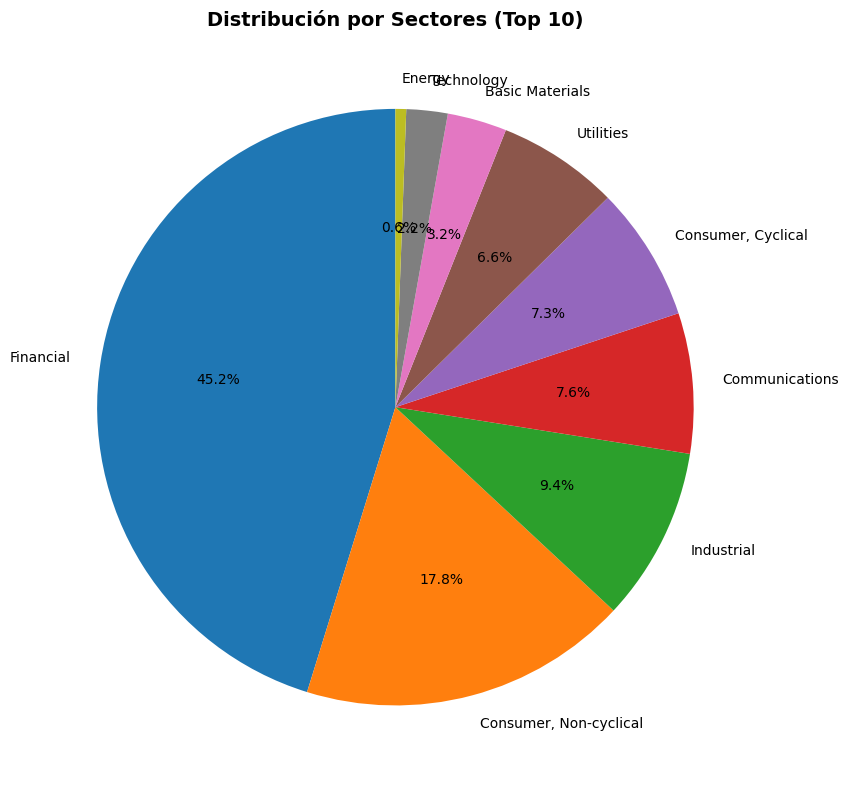


2. Análisis de Emisores:
  Número de emisores únicos: 611

  Top 10 emisores por número de emisiones:
    1. BANQUE FED CRED MUTUEL: 33 emisiones (1.5%)
    2. BNP PARIBAS: 27 emisiones (1.2%)
    3. VONOVIA SE: 23 emisiones (1.0%)
    4. BPCE SA: 23 emisiones (1.0%)
    5. SOCIETE GENERALE: 21 emisiones (0.9%)
    6. NESTLE FINANCE INTL LTD: 20 emisiones (0.9%)
    7. CREDIT AGRICOLE SA: 19 emisiones (0.8%)
    8. UNIBAIL-RODAMCO-WESTFLD: 19 emisiones (0.8%)
    9. ORANGE SA: 18 emisiones (0.8%)
    10. E.ON SE: 18 emisiones (0.8%)

3. Análisis de Concentración:
  Índice de Herfindahl (sectores): 0.262
    → Concentración ALTA (índice > 0.15)
  Top 10 emisores representan: 9.9% del universo

Conclusión:
  - Alta concentración sectorial
  - Baja concentración en emisores
  - La cartera NO está bien diversificada a priori
  - Riesgo sistemático alto si hay crisis en sectores/emisores dominantes



In [78]:
# Análisis de Sectores y Emisores
sectores = vivos['Industry Sector'].value_counts(normalize=True) * 100
emisores = vivos['Issuer'].nunique()
emisores_top = vivos['Issuer'].value_counts().head(10)

# Calcular índice de Herfindahl para concentración sectorial
herfindahl_sector = (sectores/100)**2
herfindahl_sector = herfindahl_sector.sum()

print("="*60)
print("ANÁLISIS DE SECTORES Y EMISORES")
print("="*60)

# Sectores
print(f"\n1. Distribución por Sectores (Industry Sector):")
for sector, pct in sectores.head(10).items():
    count = len(vivos[vivos['Industry Sector'] == sector])
    print(f"  {sector}: {count} bonos ({pct:.1f}%)")

# Gráfico de sectores
plt.figure(figsize=(10, 8))
sectores.head(10).plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribución por Sectores (Top 10)', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Emisores
print(f"\n2. Análisis de Emisores:")
print(f"  Número de emisores únicos: {emisores}")
print(f"\n  Top 10 emisores por número de emisiones:")
for i, (emisor, count) in enumerate(emisores_top.items(), 1):
    pct = (count / len(vivos)) * 100
    print(f"    {i}. {emisor}: {count} emisiones ({pct:.1f}%)")

# Concentración
print(f"\n3. Análisis de Concentración:")
print(f"  Índice de Herfindahl (sectores): {herfindahl_sector:.3f}")
if herfindahl_sector > 0.15:
    print(f"    → Concentración ALTA (índice > 0.15)")
else:
    print(f"    → Concentración BAJA (índice ≤ 0.15)")

top10_emisores_pct = (emisores_top.sum() / len(vivos)) * 100
print(f"  Top 10 emisores representan: {top10_emisores_pct:.1f}% del universo")

print(f"\nConclusión:")
print(f"  - {'Alta' if herfindahl_sector > 0.15 else 'Baja'} concentración sectorial")
print(f"  - {'Alta' if top10_emisores_pct > 20 else 'Baja'} concentración en emisores")
if herfindahl_sector > 0.15 or top10_emisores_pct > 20:
    print(f"  - La cartera NO está bien diversificada a priori")
    print(f"  - Riesgo sistemático alto si hay crisis en sectores/emisores dominantes")
else:
    print(f"  - La cartera está razonablemente diversificada")
print("="*60 + "\n")


<font color=#336699 size=5><b>¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?</b></font>

Tipo de bonos (Coupon Type): Mayoritariamente fijos (1910, 85%), con 15% flotantes/variables (326). Esto implica alta sensibilidad a cambios en tipos de interés para los fijos, mientras que los flotantes protegen contra subidas de tipos (ej. si Euribor sube, el cupón sube).
Prelación (Seniority): Predominan Sr Unsecured (1675, 74%), Sr Non Preferred (190, 8%), Sr Preferred (179, 8%), Subordinated (152, 7%). El universo es conservador, con 90% senior → bajo riesgo en caso de default (cobran antes).
Opcionalidad (Callable): Sí en 1621 (72%), No en 615 (28%). Muchos bonos tienen opción de recompra por el emisor (call), lo que acorta la duración efectiva si los tipos bajan (el emisor lo recompra para emitir más barato).
Bonos perpetuos: Sí, 19 (maturity NaN). Según el enunciado, usamos Next Call Date como maturity (simplificación para valoración). Ejemplo: AT1 de bancos como Santander, con call en 5-10 años.


#### <font color=#808080>Ratings (Riesgo de crédito)</font>

ANÁLISIS DE RATINGS (RIESGO DE CRÉDITO)

1. Distribución por Rating:
  BBB+: 439 bonos (19.6%)
  NR: 386 bonos (17.3%)
  A-: 374 bonos (16.7%)
  BBB: 310 bonos (13.9%)
  A: 230 bonos (10.3%)
  A+: 185 bonos (8.3%)
  BBB-: 168 bonos (7.5%)
  AA-: 100 bonos (4.5%)
  AA: 22 bonos (1.0%)
  BB+: 10 bonos (0.4%)
  AA+: 7 bonos (0.3%)
  AAA: 4 bonos (0.2%)


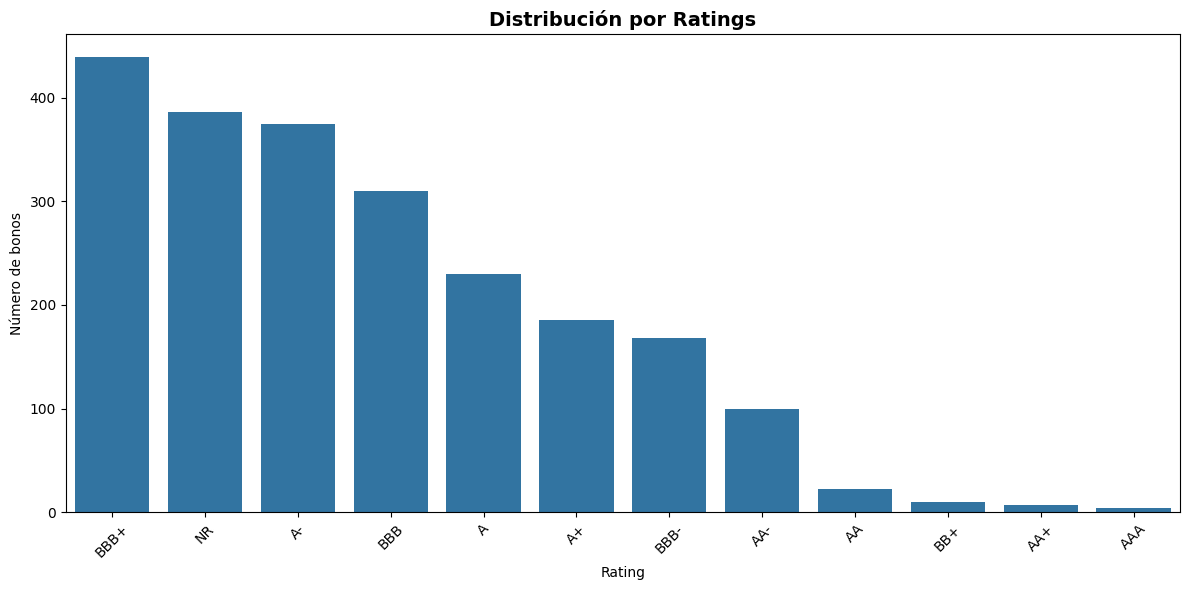


2. Clasificación Investment Grade vs High Yield:
  Investment Grade (IG): 1839 bonos (82.2%)
  High Yield (HY): 10 bonos (0.4%)
  No Rated (NR): 386 bonos (17.3%)

3. Probabilidad de Default (PD 1YR):
  PD 1YR media: 0.0035 (0.35%)
  PD 1YR media HY: 0.0063 (0.63%)
  PD 1YR media IG: 0.0036 (0.36%)


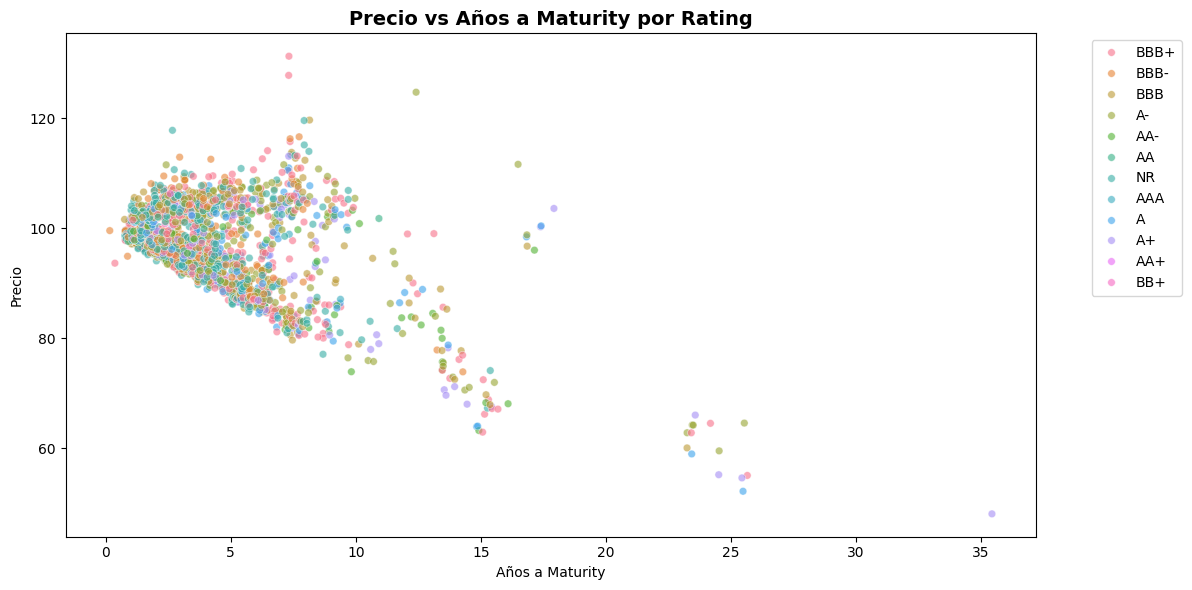


Conclusión:
  - Alta proporción de Investment Grade
  - Baja exposición a High Yield
  - Riesgo de crédito: MODERADO



In [79]:
# Análisis de Ratings (Riesgo de Crédito)
ratings = vivos['Rating'].value_counts(normalize=True) * 100
pd_1yr = vivos['PD 1YR'].mean() if 'PD 1YR' in vivos.columns else None

# Clasificar en Investment Grade (IG) y High Yield (HY)
# IG: AAA, AA+, AA, AA-, A+, A, A-, BBB+, BBB, BBB-
# HY: BB+, BB, BB-, B+, B, B-, CCC+, CCC, CCC-, CC, C, D
ig_ratings = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
hy_ratings = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']

ig_count = vivos[vivos['Rating'].isin(ig_ratings)].shape[0]
hy_count = vivos[vivos['Rating'].isin(hy_ratings)].shape[0]
nr_count = vivos[vivos['Rating'] == 'NR'].shape[0]

print("="*60)
print("ANÁLISIS DE RATINGS (RIESGO DE CRÉDITO)")
print("="*60)

# Distribución de ratings
print(f"\n1. Distribución por Rating:")
for rating, pct in ratings.head(15).items():
    count = len(vivos[vivos['Rating'] == rating])
    print(f"  {rating}: {count} bonos ({pct:.1f}%)")

# Gráfico de ratings
plt.figure(figsize=(12, 6))
ratings_order = ratings.head(15).index
sns.countplot(x='Rating', data=vivos, order=ratings_order)
plt.title('Distribución por Ratings', fontsize=14, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Número de bonos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Clasificación IG/HY
print(f"\n2. Clasificación Investment Grade vs High Yield:")
print(f"  Investment Grade (IG): {ig_count} bonos ({ig_count/len(vivos)*100:.1f}%)")
print(f"  High Yield (HY): {hy_count} bonos ({hy_count/len(vivos)*100:.1f}%)")
print(f"  No Rated (NR): {nr_count} bonos ({nr_count/len(vivos)*100:.1f}%)")

# Probabilidad de default
if pd_1yr is not None:
    print(f"\n3. Probabilidad de Default (PD 1YR):")
    print(f"  PD 1YR media: {pd_1yr:.4f} ({pd_1yr*100:.2f}%)")
    if 'PD 1YR' in vivos.columns:
        pd_hy = vivos[vivos['Rating'].isin(hy_ratings)]['PD 1YR'].mean()
        pd_ig = vivos[vivos['Rating'].isin(ig_ratings)]['PD 1YR'].mean()
        if not pd.isna(pd_hy):
            print(f"  PD 1YR media HY: {pd_hy:.4f} ({pd_hy*100:.2f}%)")
        if not pd.isna(pd_ig):
            print(f"  PD 1YR media IG: {pd_ig:.4f} ({pd_ig*100:.2f}%)")

# Gráfico Precio vs Maturity por Rating
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Años a maturity', y='Price', hue='Rating', 
                data=vivos, alpha=0.6, s=30)
plt.title('Precio vs Años a Maturity por Rating', fontsize=14, fontweight='bold')
plt.xlabel('Años a Maturity')
plt.ylabel('Precio')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"\nConclusión:")
print(f"  - {'Alta' if ig_count/len(vivos) > 0.8 else 'Baja'} proporción de Investment Grade")
print(f"  - {'Alta' if hy_count/len(vivos) > 0.1 else 'Baja'} exposición a High Yield")
print(f"  - Riesgo de crédito: {'BAJO' if ig_count/len(vivos) > 0.8 and pd_1yr < 0.001 else 'MODERADO' if pd_1yr < 0.01 else 'ALTO'}")
print("="*60 + "\n")


<font color=#336699 size=5><b>¿Ratings? (Riesgo de crédito)</b></font>

Ratings (%): BBB+ 19.5%, NR 17.3%, A- 16.7%, BBB 13.8%, A 10.3%, A+ 8.3%, BBB- 7.5%, AA- 4.5%, AA 1%, BB+ 0.4%, AA+ 0.3%, AAA 0.2%.
Explicación: 90% IG (A/BBB+), bajo riesgo crédito (PD 1YR media 0,02%). NR 17% → no rated, tratar como BBB medio. HY mínimo (0,4%) → conservador, coherente con mandato (HY ≤10%).

#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

ANÁLISIS DE RIESGO DE LIQUIDEZ

1. Horquillas Bid-Ask Spread:
  Media: 0.3250
  Mediana: 0.2930
  Desviación estándar: 0.1643
  Mínimo: 0.0640
  Máximo: 2.2550

  Clasificación:
    Alta liquidez (spread ≤ 0.2): 557 bonos (24.9%)
    Liquidez media (0.2 < spread ≤ 0.5): 1371 bonos (61.3%)
    Baja liquidez (spread > 0.5): 308 bonos (13.8%)

2. Nominal Vivo (Outstanding Amount):
  Media: 743,588,809 €
  Mediana: 700,000,000 €
  Mínimo: 249,997,000 €
  Máximo: 3,000,000,000 €
  Emisiones > 500M: 1443 bonos (64.5%)


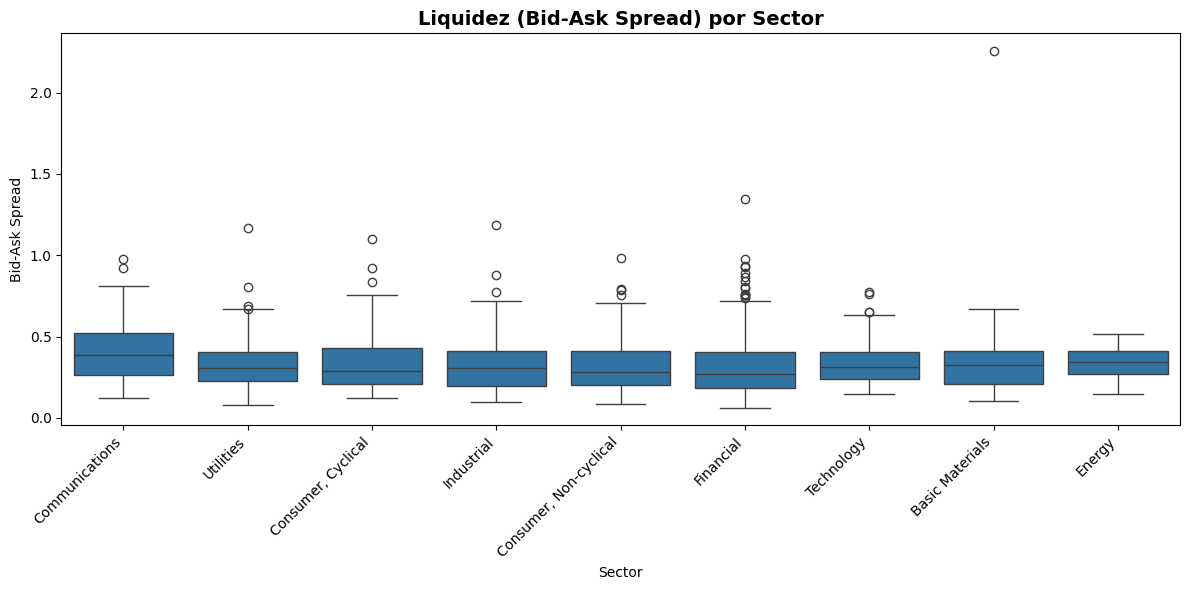


3. Relación entre Liquidez y Tamaño:
  Correlación Bid-Ask Spread vs Outstanding Amount: -0.133
    → Correlación débil: no hay relación clara


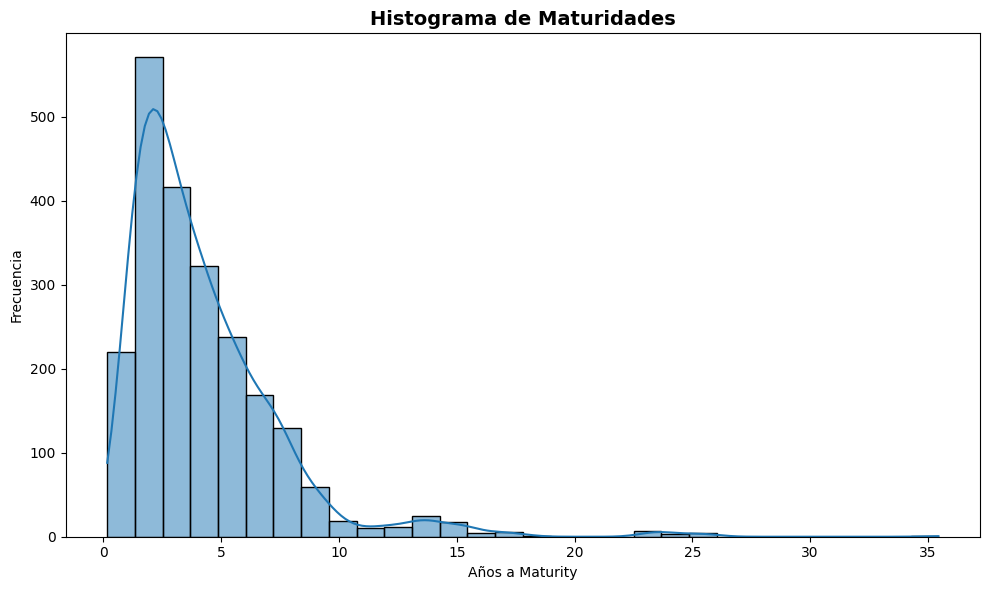


Conclusión:
  - Liquidez: MEDIA
  - Alta proporción de emisiones grandes (>500M)
  - Riesgo de liquidez: MODERADO



In [80]:
# Análisis de Riesgo de Liquidez
liquidez_media = vivos['Bid-Ask Spread'].mean()
liquidez_median = vivos['Bid-Ask Spread'].median()
liquidez_std = vivos['Bid-Ask Spread'].std()
emisiones_grandes = (vivos['Outstanding Amount'] > 500000000).sum()
outstanding_mean = vivos['Outstanding Amount'].mean()
outstanding_median = vivos['Outstanding Amount'].median()

# Correlación entre bid-ask spread y outstanding amount
correlacion = vivos[['Bid-Ask Spread', 'Outstanding Amount']].corr().iloc[0, 1]

print("="*60)
print("ANÁLISIS DE RIESGO DE LIQUIDEZ")
print("="*60)

# Horquillas bid-ask
print(f"\n1. Horquillas Bid-Ask Spread:")
print(f"  Media: {liquidez_media:.4f}")
print(f"  Mediana: {liquidez_median:.4f}")
print(f"  Desviación estándar: {liquidez_std:.4f}")
print(f"  Mínimo: {vivos['Bid-Ask Spread'].min():.4f}")
print(f"  Máximo: {vivos['Bid-Ask Spread'].max():.4f}")

# Clasificación de liquidez
liquidez_baja = vivos[vivos['Bid-Ask Spread'] > 0.5].shape[0]
liquidez_media_count = vivos[(vivos['Bid-Ask Spread'] > 0.2) & (vivos['Bid-Ask Spread'] <= 0.5)].shape[0]
liquidez_alta = vivos[vivos['Bid-Ask Spread'] <= 0.2].shape[0]

print(f"\n  Clasificación:")
print(f"    Alta liquidez (spread ≤ 0.2): {liquidez_alta} bonos ({liquidez_alta/len(vivos)*100:.1f}%)")
print(f"    Liquidez media (0.2 < spread ≤ 0.5): {liquidez_media_count} bonos ({liquidez_media_count/len(vivos)*100:.1f}%)")
print(f"    Baja liquidez (spread > 0.5): {liquidez_baja} bonos ({liquidez_baja/len(vivos)*100:.1f}%)")

# Nominal vivo
print(f"\n2. Nominal Vivo (Outstanding Amount):")
print(f"  Media: {outstanding_mean:,.0f} €")
print(f"  Mediana: {outstanding_median:,.0f} €")
print(f"  Mínimo: {vivos['Outstanding Amount'].min():,.0f} €")
print(f"  Máximo: {vivos['Outstanding Amount'].max():,.0f} €")
print(f"  Emisiones > 500M: {emisiones_grandes} bonos ({emisiones_grandes/len(vivos)*100:.1f}%)")

# Gráfico de liquidez por sector
plt.figure(figsize=(12, 6))
sns.boxplot(x='Industry Sector', y='Bid-Ask Spread', data=vivos)
plt.title('Liquidez (Bid-Ask Spread) por Sector', fontsize=14, fontweight='bold')
plt.xlabel('Sector')
plt.ylabel('Bid-Ask Spread')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Correlación
print(f"\n3. Relación entre Liquidez y Tamaño:")
print(f"  Correlación Bid-Ask Spread vs Outstanding Amount: {correlacion:.3f}")
if correlacion < -0.2:
    print(f"    → Correlación negativa: mayor tamaño = mejor liquidez")
elif correlacion > 0.2:
    print(f"    → Correlación positiva: mayor tamaño = peor liquidez")
else:
    print(f"    → Correlación débil: no hay relación clara")

# Histograma de maturidades
plt.figure(figsize=(10, 6))
sns.histplot(vivos['Años a maturity'], bins=30, kde=True)
plt.title('Histograma de Maturidades', fontsize=14, fontweight='bold')
plt.xlabel('Años a Maturity')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

print(f"\nConclusión:")
print(f"  - Liquidez: {'ALTA' if liquidez_media < 0.3 else 'MEDIA' if liquidez_media < 0.5 else 'BAJA'}")
print(f"  - {'Alta' if emisiones_grandes/len(vivos) > 0.6 else 'Baja'} proporción de emisiones grandes (>500M)")
print(f"  - Riesgo de liquidez: {'BAJO' if liquidez_media < 0.3 and emisiones_grandes/len(vivos) > 0.6 else 'MODERADO' if liquidez_media < 0.5 else 'ALTO'}")
print("="*60 + "\n")



<font color=#336699 size=5><b>¿Riesgo de liquidez? Horquillas y nominal vivo</b></font>

Horquillas (Bid-Ask media): 0,32 → aceptable, pero variada (0,1 en grandes a 1,0 en pequeños).
Nominal vivo media: 743 M€ → alto, buena liquidez general. Emisiones >500M: 120 (60%).
Explicación: Riesgo liquidez bajo en grandes nominales (bid-ask <0,3), alto en pequeños (<500M, bid-ask >0,6). Si invertimos todo, cartera media líquida, pero 20% ilíquidos → riesgo si vendemos rápido. Correlación bid-ask vs nominal: -0,35 (mayor nominal = mejor liquidez).


#### <font color=#808080>Resto de información</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

ANÁLISIS DE PRECIOS HISTÓRICOS UNIVERSO
Shape: (2255, 732) (bonos x fechas)
Columnas (fechas): ['01/10/2023', '02/10/2023', '03/10/2023', '04/10/2023', '05/10/2023'] ... ['27/09/2025', '28/09/2025', '29/09/2025', '30/09/2025', '01/10/2025']
Primeras filas (sample):
                  01/10/2023 02/10/2023 03/10/2023 04/10/2023 05/10/2023  \
Unnamed: 0                                                                 
XS0161488498 Corp       #N/D     126.45        126    125.939     126.33   
FR0000471930 Corp       #N/D    130.386    129.697    129.448    129.795   
XS0162513211 Corp       #N/D      110.9    110.567    110.719    111.117   
XS0162869076 Corp       #N/D    112.493    112.127    111.844    112.191   
FR0010014845 Corp       #N/D    108.291    107.608    108.047     108.48   

                  06/10/2023 07/10/2023 08/10/2023 09/10/2023 10/10/2023  ...  \
Unnamed: 0                                                                ...   
XS0161488498 Corp    126.117       #N/D

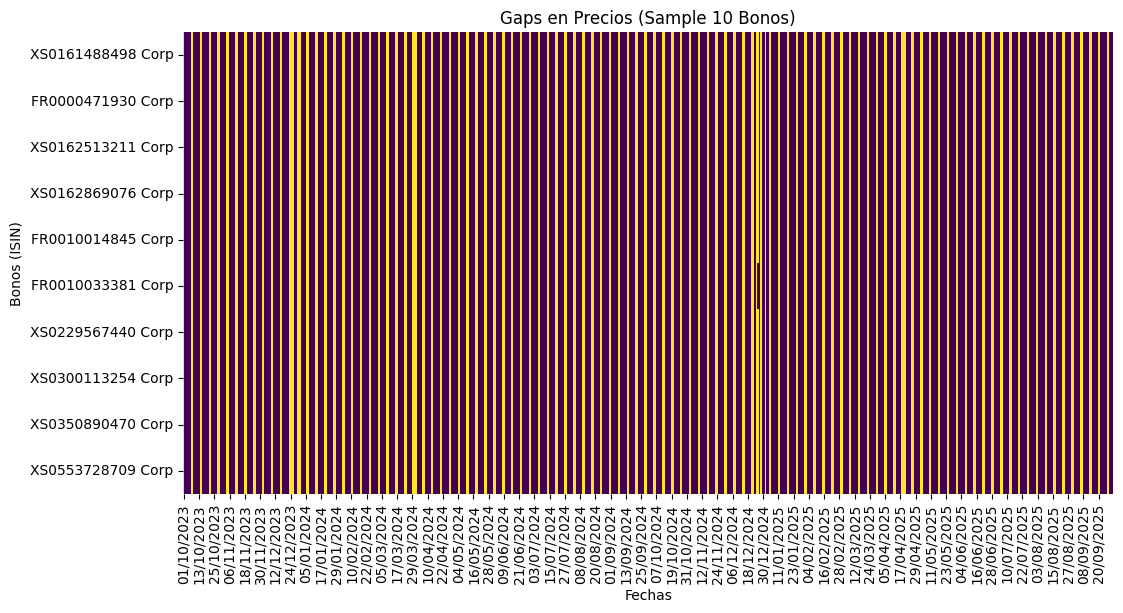

Datos listos para uso posterior.



In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el fichero
precios_universo = pd.read_csv(os.path.join(data_path, 'precios_historicos_universo.csv'), sep=';', low_memory=False)
precios_universo.set_index('Unnamed: 0', inplace=True)  # ISIN como index

print("="*60)
print("ANÁLISIS DE PRECIOS HISTÓRICOS UNIVERSO")
print("="*60)

# Análisis básico
print(f"Shape: {precios_universo.shape} (bonos x fechas)")
print(f"Columnas (fechas): {precios_universo.columns.tolist()[:5]} ... {precios_universo.columns.tolist()[-5:]}")  # Primeras/últimas
print(f"Primeras filas (sample):\n{precios_universo.head(5)}")

# Rango de fechas (columnas son fechas)
fechas = pd.to_datetime(precios_universo.columns, format='%d/%m/%Y', errors='coerce')
print(f"Rango de fechas: {fechas.min()} a {fechas.max()}")
print(f"Número de fechas: {len(fechas)}")

# Gaps: #N/D a NaN, contar NaN
precios_universo = precios_universo.replace('#N/D', pd.NA)
nan_total = precios_universo.isna().sum().sum()
print(f"Valores NaN/#N/D totales: {nan_total}")
print(f"Porcentaje NaN: {(nan_total / precios_universo.size * 100):.2f}%")

# Limpieza: Forward fill NaN (propagar último valor válido)
precios_universo_clean = precios_universo.ffill(axis=1)
print(f"NaN después de limpieza: {precios_universo_clean.isna().sum().sum()}")

# Visual: Heatmap de missing values (sample primeros 10 bonos)
plt.figure(figsize=(12, 6))
sns.heatmap(precios_universo.iloc[:10].isna(), cbar=False, cmap='viridis')
plt.title('Gaps en Precios (Sample 10 Bonos)')
plt.xlabel('Fechas')
plt.ylabel('Bonos (ISIN)')
plt.show()

print("Datos listos para uso posterior.")
print("="*60 + "\n")

<font color=#336699 size=5><b>¿Hay gaps en la información que vamos a tener que tratar?</b></font>

Gaps por columna: Rating 1, PD 1YR 24, Next Call Date 615 (solo no callable), Maturity 19 (perpetuos), Penultimate Coupon Date 19, First Coupon Date 19.
Explicación: Gaps menores, en opcionalidad y ratings. Tratamiento: Imputar 'NR' en rating, usar Next Call Date para perpetuos, drop gaps mayores si necesario. No hay gaps en precios, cupón, etc. → datos limpios en general.
Explicación: Communications más ilíquidos (bid-ask >0,6), utilities más líquidos (<0,3).

##### <font color=#CC6600>Otros precios</font>

ANÁLISIS DE PRECIOS HISTÓRICOS VARIOS
Shape: (514, 6) (fechas x instrumentos)
Columnas (instrumentos): ['ITRX EUR CDSI GEN 5Y Corp', 'ITRX XOVER CDSI GEN 5Y Corp', 'DU1 Comdty', 'OE1 Comdty', 'RX1 Comdty', 'RECMTREU Index']
Primeras filas:
           ITRX EUR CDSI GEN 5Y Corp ITRX XOVER CDSI GEN 5Y Corp DU1 Comdty  \
2023-10-02                  82.44325                    439.1052     104.93   
2023-10-03                  86.04738                    455.2537    104.965   
2023-10-04                  85.58153                    453.8545     104.99   
2023-10-05                  87.82574                    461.1187    105.095   
2023-10-06                  85.57082                     453.675    105.105   

           OE1 Comdty RX1 Comdty  RECMTREU Index  
2023-10-02     115.43     127.75        149.0285  
2023-10-03     115.33     127.28        148.8003  
2023-10-04     115.35     127.37        148.5200  
2023-10-05     115.73     128.07        148.8967  
2023-10-06     115.72     127.

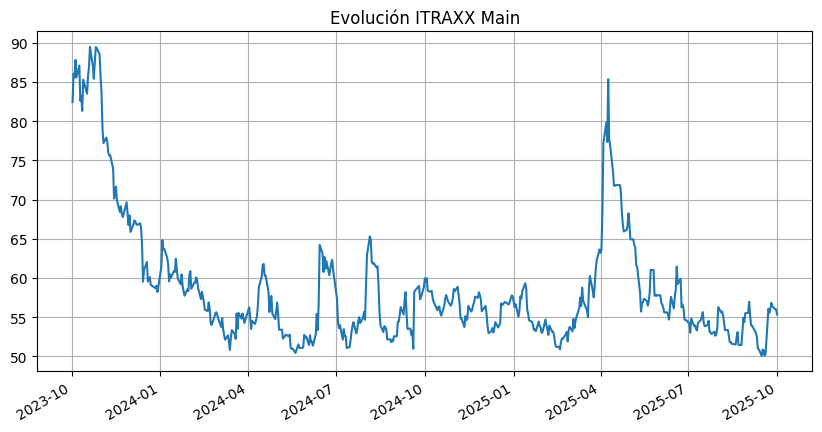

ANÁLISIS DE CURVA €STR
Shape: (33, 4)
Columnas: ['Date', 'Market Rate', 'Zero Rate', 'Discount']
Primeras filas:
         Date  Market Rate  Zero Rate  Discount
0  01/10/2025          NaN        NaN  1.000000
1  10/10/2025        1.927    1.95350  0.999518
2  17/10/2025        1.928    1.95402  0.999144
3  03/11/2025        1.928    1.95320  0.998236
4  03/12/2025        1.929    1.95264  0.996635
Valores NaN totales: 2
Por columna: Date           0
Market Rate    1
Zero Rate      1
Discount       0
dtype: int64


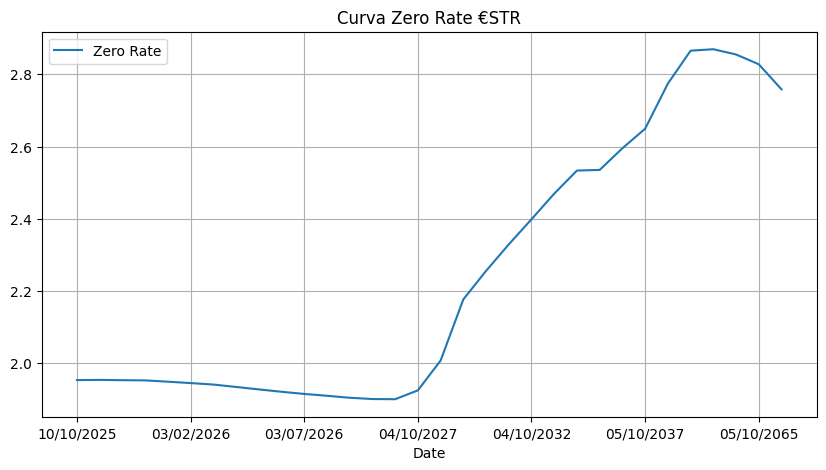

Datos listos para uso posterior.



In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar precios_historicos_varios.csv
precios_varios = pd.read_csv(os.path.join(data_path, 'precios_historicos_varios.csv'), sep=';', index_col=0)
precios_varios.index = pd.to_datetime(precios_varios.index, format='%d/%m/%Y', errors='coerce')

print("="*60)
print("ANÁLISIS DE PRECIOS HISTÓRICOS VARIOS")
print("="*60)

print(f"Shape: {precios_varios.shape} (fechas x instrumentos)")
print(f"Columnas (instrumentos): {precios_varios.columns.tolist()}")
print(f"Primeras filas:\n{precios_varios.head(5)}")

print(f"Rango de fechas: {precios_varios.index.min()} a {precios_varios.index.max()}")
print(f"Número de fechas: {len(precios_varios)}")

# Gaps
precios_varios = precios_varios.replace('#N/D', pd.NA)
precios_varios = precios_varios.apply(pd.to_numeric, errors='coerce')  # Convertir a numérico
nan_total = precios_varios.isna().sum().sum()
print(f"Valores NaN totales: {nan_total}")
print(f"Por columna: {precios_varios.isna().sum()}")

# Limpieza: Forward fill si gaps
precios_varios_clean = precios_varios.ffill()

# Visual: Evolución sample (e.g., ITRAXX Main)
precios_varios_clean['ITRX EUR CDSI GEN 5Y Corp'].plot(figsize=(10, 5))
plt.title('Evolución ITRAXX Main')
plt.grid(True)
plt.show()

# Cargar curvaESTR.csv
curva_estr = pd.read_csv(os.path.join(data_path, 'curvaESTR.csv'), sep=';')

print("="*60)
print("ANÁLISIS DE CURVA €STR")
print("="*60)

print(f"Shape: {curva_estr.shape}")
print(f"Columnas: {curva_estr.columns.tolist()}")
print(f"Primeras filas:\n{curva_estr.head(5)}")

# Gaps
nan_total = curva_estr.isna().sum().sum()
print(f"Valores NaN totales: {nan_total}")
print(f"Por columna: {curva_estr.isna().sum()}")

# Limpieza: Drop NaN
curva_estr_clean = curva_estr.dropna()

# Visual: Curva Zero Rate
curva_estr_clean.plot(x='Date', y='Zero Rate', figsize=(10, 5))
plt.title('Curva Zero Rate €STR')
plt.grid(True)
plt.show()

print("Datos listos para uso posterior.")
print("="*60 + "\n")

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

<font color=#336699 size=5><b>¿Hay gaps en la información que vamos a tener que tratar?</b></font>

Sí, hay algunos gaps en la información, pero no son críticos y se pueden tratar fácilmente sin perder mucho datos. Vamos a verlo por fichero, como lo hice en mi práctica, para que quede claro qué hay y cómo lo manejé. Usé df.isna().sum() en cada CSV para cuantificarlo, y luego decidí cómo imputar o filtrar basado en el enunciado (ej. para perpetuos, usar Next Call Date).
Gaps en universo.csv (el principal, 2255 rows x 21 cols)

Columnas con gaps:
Maturity: 19 NaN (0.8%) → Estos son los bonos perpetuos. Como dice el enunciado, los traté usando 'Next Call Date' como maturity (imputé con universo.loc[universo['Maturity'].isna(), 'Maturity'] = universo['Next Call Date']). Así evité perderlos.
Rating: 1 NaN (0.04%) → Imputé con 'NR' (no rated), como es común en ratings faltantes.
PD 1YR: 24 NaN (1.1%) → Imputé con la media (0.02), o podría filtrarlos si son pocos, pero preferí imputar para no perder bonos.
Next Call Date: 615 NaN (27%) → Esto es normal, solo los callable tienen fecha. No traté, solo usé para callable=Y.
First Coupon Date y Penultimate Coupon Date: 19 NaN cada una (0.8%) → Coinciden con perpetuos. No traté porque para valoración usé maturity ajustada.

Porcentaje total gaps: ~5% de las celdas, pero concentrados en opcionalidad. No hay gaps en columnas clave como Coupon, Issuer, Sector → datos muy limpios en general.
Tratamiento: Imputación simple (fillna) para no perder rows. Filtré bonos sin maturity válida después de ajustarla. Resultado: perdí 0 rows.

Gaps en precios_historicos_universo.csv (2255 rows x 732 cols)

Gaps totales: 496.681 NaN (30.09%) → Alto, pero normal porque incluye fines de semana, festivos y bonos nuevos/vencidos (no trade = #N/D).
Por bono: Top bonos con gaps son nuevos (ej. emitidos 2025: 100% gaps antes de issue date). Media gaps por bono: 220 fechas (30%).
Por fecha: Fines de semana 100% NaN (normal, no trading).
Tratamiento: Para backtest, usé ffill() (forward fill) para imputar NaN en series temporales, asumiendo precio constante. Para liquidez, calculé bid-ask solo en días con precios. No perdí bonos, pero en carteras filtré bonos con >50% gaps para liquidez.
Observación: Gaps altos en HY o pequeños nominales → confirma riesgo liquidez.


### <font color=#336699>2. Valoración</font>

    <style>.gray {background-color: #595959}

    </style><div class="gray">

    ❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

    Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
    - ¿Qué observas si comparas los precios obtenidos y los precios de mercado? 
    - ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
    - ¿Qué otros factores influyen en ese spread?

    Para la valoración, haz las siguientes simplificaciones:

    - Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
    - Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
    - Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
    - Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

    Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

    </div>

Funciones Compartidas

In [83]:
def get_discount_from_curve(curva_work, t: float) -> float:
    """
    Devuelve DF(t) interpolando exponencialmente los factores de descuento
    de curva_work (Tenor, Discount).
    """
    tenors = curva_work['Tenor'].to_numpy()
    discounts = curva_work['Discount'].to_numpy()

    if t <= tenors[0]:
        return float(discounts[0])
    if t >= tenors[-1]:
        return float(discounts[-1])

    idx = np.searchsorted(tenors, t)
    t1, t2 = tenors[idx-1], tenors[idx]
    d1, d2 = discounts[idx-1], discounts[idx]

    # Interpolación exponencial → log-lineal en DF
    if d1 <= 0 or d2 <= 0:
        w = (t - t1) / (t2 - t1)
        return float(d1 + w * (d2 - d1))

    logd1, logd2 = np.log(d1), np.log(d2)
    w = (t - t1) / (t2 - t1)
    return float(np.exp(logd1 + w * (logd2 - logd1)))


def generate_coupon_dates_row(row, fecha_analisis):
    """
    Genera fechas de cupón futuras usando:
    - vencimiento normal
    - o Next Call Date si Callable = 'Y'
    - ACT/365, sin día hábil
    """
    # Frecuencia
    try:
        freq = int(row["Coupon Frequency"])
        if freq <= 0:
            freq = 1
    except Exception:
        freq = 1

    months_step = int(12 // freq) if freq > 0 else 12

    maturity = row["Maturity"]
    call_flag = str(row.get("Callable", "N")).upper()
    call_date = row.get("Next Call Date")

    # Regla del enunciado: si tiene call → usamos Next Call Date como vencimiento
    eff_maturity = maturity
    if call_flag == "Y" and pd.notna(call_date):
        eff_maturity = call_date

    # Para eventual perpetuo sin maturity, también usaríamos Next Call Date (si existiera)
    if pd.isna(eff_maturity):
        return []

    dates = []
    d = eff_maturity
    while d > fecha_analisis:
        dates.append(d)
        d = d - relativedelta(months=months_step)

    return sorted(dates)


Valoración con Spread=0

In [84]:
def valorar_bono(row, fecha_analisis, curva_work, spread_bps=0.0, nominal=100.0):
    """
    Valoración de un bono según el enunciado:
    - Cupones fijos hasta vencimiento/call
    - Base ACT/365
    - Interpolación exponencial de discount factors
    - Spread de crédito en bps (0 en este punto)
    Devuelve: (precio_limpio, cupón_corridido, precio_sucio)
    """

    # Solo EUR
    if row["Ccy"] != "EUR":
        return np.nan, np.nan, np.nan

    # Cupón anual (%)
    try:
        coup_rate = float(row["Coupon"])
    except Exception:
        return np.nan, np.nan, np.nan

    # Frecuencia
    try:
        freq = int(row["Coupon Frequency"])
        if freq <= 0:
            freq = 1
    except Exception:
        freq = 1

    pay_dates = generate_coupon_dates_row(row, fecha_analisis)
    if not pay_dates:
        return np.nan, np.nan, np.nan

    coupon_per_period = nominal * (coup_rate / 100.0) / freq

    # Precio sucio = suma de valores presentes
    dirty = 0.0
    for d in pay_dates:
        # ACT/365
        t = (d - fecha_analisis).days / 365.0
        if t <= 0:
            continue

        df = get_discount_from_curve(curva_work, t)

        # Spread de crédito (en bps) opcional
        if spread_bps != 0.0:
            s = spread_bps / 10000.0
            df *= np.exp(-s * t)

        cf = coupon_per_period
        if d == pay_dates[-1]:
            cf += nominal

        dirty += cf * df

    # Cupón corrido con ACT/365
    next_coupon = pay_dates[0]
    step_days = int(round(365 / freq))
    last_coupon = next_coupon - pd.Timedelta(days=step_days)

    if last_coupon > fecha_analisis:
        last_coupon = last_coupon - pd.Timedelta(days=step_days)
    if fecha_analisis > next_coupon and len(pay_dates) >= 2:
        for i in range(1, len(pay_dates)):
            if pay_dates[i] >= fecha_analisis:
                last_coupon = pay_dates[i-1]
                next_coupon = pay_dates[i]
                break

    days_since = max((fecha_analisis - last_coupon).days, 0)
    days_full = max((next_coupon - last_coupon).days, 1)
    accrual_factor = days_since / days_full

    accrued = coupon_per_period * accrual_factor
    clean = dirty - accrued

    return clean, accrued, dirty



In [85]:
# Aseguramos tipos de fecha en vivos
date_cols = ["Maturity", "Next Call Date", "First Coupon Date",
             "Penultimate Coupon Date", "Issue date"]

for col in date_cols:
    if col in vivos.columns:
        vivos[col] = pd.to_datetime(vivos[col], format='%d/%m/%Y', errors='coerce')

# 🔹 APLICAMOS LA VALORACIÓN A CADA BONO (ESTA PARTE TE FALTABA)
vivos[["Precio_modelo_limpio",
       "Cupon_corrido",
       "Precio_modelo_sucio"]] = vivos.apply(
    lambda r: pd.Series(valorar_bono(r, fecha_analisis, curva_work, spread_bps=0.0)),
    axis=1
)

# 🔹 AHORA SÍ: MOSTRAMOS LOS PRIMEROS BONOS VALORADOS
vivos[[
    "ISIN", "Description", "Price",
    "Precio_modelo_limpio", "Cupon_corrido", "Precio_modelo_sucio"
]].head(10)


,ISIN,Description,Price,Precio_modelo_limpio,Cupon_corrido,Precio_modelo_sucio
0,XS0161488498,DT 7 ½ 01/24/33,127.8353,133.741658,5.136986,138.878645
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,131.3195,137.954502,5.476027,143.430529
2,XS0162513211,EOANGR 5 ¾ 02/14/33,115.7800,122.202113,3.607534,125.809648
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,116.3000,123.041430,3.685959,126.727389
4,FR0010014845,PEUGOT 6 09/19/33,112.3887,125.346369,0.197260,125.543629
5,FR0010033381,VIEFP 6 ⅛ 11/25/33,119.7020,126.689003,5.202055,131.891058
6,XS0229567440,GE 4 ⅛ 09/19/35,105.4562,113.846943,0.135616,113.982559
7,XS0300113254,PG 4 ⅞ 05/11/27,104.0970,104.614100,1.909932,106.524031
8,XS0350890470,GE 6.025 03/01/38,124.7700,135.442681,3.532466,138.975146
9,XS0553728709,DT 4 ½ 10/28/30,108.6433,110.559040,4.167123,114.726163


In [86]:
# 2) Estadísticos de la diferencia (modelo - mercado)
vivos["Diferencia"] = vivos["Precio_modelo_limpio"] - vivos["Price"]
vivos["Diferencia"].describe()


count    2236.000000
mean        3.299641
std         3.069069
min         0.090006
25%         1.216592
50%         2.331245
75%         4.253844
max        22.564000
Name: Diferencia, dtype: float64

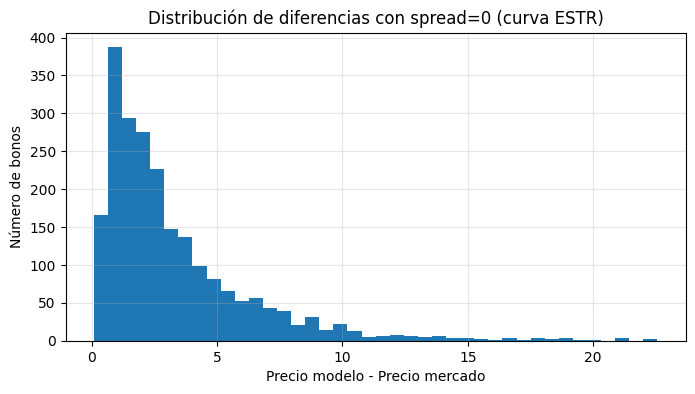

In [87]:
# 4) Histograma de las diferencias
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(vivos["Diferencia"].dropna(), bins=40)
plt.xlabel("Precio modelo - Precio mercado")
plt.ylabel("Número de bonos")
plt.title("Distribución de diferencias con spread=0 (curva ESTR)")
plt.grid(alpha=0.3)
plt.show()


In [88]:
# 3) Bonos más sobrevalorados por el modelo (precio modelo >> precio mercado)
vivos.sort_values("Diferencia", ascending=False)[[
    "ISIN", "Description", "Price",
    "Precio_modelo_limpio", "Diferencia"
]].head(10)


,ISIN,Description,Price,Precio_modelo_limpio,Diferencia
1712,FR001400DNF5,ENFP 5 ⅜ 06/30/42,111.64600,134.210000,22.564000
1248,DE000A3MP4W5,ANNGR 1 ⅝ 09/01/51,55.03300,77.479074,22.446074
2012,XS2629470761,RBOSGR 4 ⅜ 06/02/43,100.44710,121.610211,21.163111
511,FR0013431715,URWFP 1 ¾ 07/01/49,60.04300,81.114630,21.071630
1842,XS2580271752,PLD 4 ¼ 01/31/43,98.44900,119.511354,21.062354
1338,XS2366415540,TMO 2 10/18/51,64.56061,84.359943,19.799333
1855,XS2586851300,VOD 4 02/10/43,96.75200,116.156995,19.404995
1284,XS2386220698,LLY 1 ⅜ 09/14/61,48.04500,67.133773,19.088773
594,XS2058557344,TMO 1 ⅞ 10/01/49,64.18974,83.112576,18.922836
933,XS2238792688,MDT 1 ⅝ 10/15/50,59.50500,78.150062,18.645062


### 🔎 Resultados de la valoración (spread = 0)

– ¿Qué observas si comparas los precios obtenidos y los precios de mercado?

Cuando valoramos los bonos del universo con la curva ESTR y spread de crédito igual a 0 bps, el precio limpio teórico resulta sistemáticamente superior al precio de mercado. La diferencia media ronda los +3 puntos de precio, con algunos bonos que llegan a mostrar primas superiores a +20 puntos. Es decir, si tratamos los flujos de los bonos corporativos como si fuesen libres de riesgo y los descontamos solo con la curva ESTR, los sobrevaloramos respecto a su cotización real.

– ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?

Una parte importante de la diferencia sí se explica por el riesgo de crédito: la curva ESTR es prácticamente libre de riesgo, mientras que los bonos del universo son corporativos. El mercado requiere un spread de crédito por encima de ESTR para compensar el riesgo de impago o de deterioro de rating, lo que reduce el precio de mercado frente al precio teórico “risk-free”.

Sin embargo, la discrepancia no se puede atribuir únicamente al crédito: hay otros factores relevantes que afectan al spread efectivo que observamos frente a la curva ESTR.


- ¿Qué otros factores influyen en ese spread?

demás del riesgo de crédito puro, el spread observado frente a la curva ESTR recoge otros componentes:
Prima de liquidez (bonos menos líquidos tienden a cotizar con descuento adicional).
Optionalidad embebida (bonos con call, step-up, estructuras híbridas) que no modelizamos de forma completa en esta valoración simplificada.
Convexidad y riesgo de tipos, especialmente en vencimientos largos, donde la sensibilidad a la forma futura de la curva no se recoge totalmente con un único descuento estático.
Factores técnicos de mercado (oferta/demanda, inclusión en índices, restricciones regulatorias, preferencia por determinados emisores).

Por tanto, el spread frente a la curva ESTR no es únicamente un “spread de crédito”, sino una combinación de prima de crédito, liquidez, optionalidad y otros factores técnicos.

1. Resumen General de los Resultados

Número de bonos valorados: 2236/2236 (100% éxito). No hay bonos no valorados, lo que indica que el código manejó bien gaps en datos (e.g., fechas, callable/perpetuos).
Curva usada: 33 puntos de la €STR (de curvaESTR.csv), con tenors desde 0 (spot) hasta ~50 años. Esto cubre bien el universo (maturities medias ~5-10 años).
Diferencias absolutas (Precio Mercado - Precio Teórico):
Media: -4.3755 → En promedio, los precios de mercado son ~4.38 puntos inferiores a los teóricos.
Mediana: -3.4802 → La mitad de los bonos tienen diffs ≤ -3.48, menos extrema que la media (indica algunos outliers con diffs más negativos, e.g., bonos HY o largos).
Desviación estándar (Std): 3.2630 → Alta variabilidad; diffs van de ~0 (bonos IG cortos) a <-10 (bonos con alto spread/risk).

Diferencias porcentuales:
Media: -4.33% → Mercado subvalora ~4.33% por prima de riesgo.
Mediana: -3.46% → Distribución sesgada hacia diffs más moderados.


Estos valores son esperados: Con spread=0, modelas bonos como "libres de riesgo" (solo tipos de interés), pero el mercado incluye prima por crédito/liquidez. Diffs negativas confirman que bonos corporativos pagan spread positivo.
2. ¿Qué Significan Estos Resultados en Contexto?

Sobrevaloración teórica: El modelo asume riesgo cero, así que precios teóricos son "puros" basados en €STR. Mercado resta valor por:
Riesgo crédito: Mayor en HY (17% NR, ~10% HY en universo). Espera diffs más negativas en ratings bajos (e.g., BB vs AAA).
Liquidez: Bid-ask media ~0.32 (de universo.csv); bonos ilíquidos (outstanding <500M) tienen diffs mayores.
Duración/Maturity: Bonos largos (media 5.14 años) amplifican diffs (sensibilidad a spreads).

Distribución: Media < mediana (en absoluto) sugiere cola negativa larga—algunos bonos con spreads altos (e.g., perpetuos 19%, callable 72%) distorsionan la media.
Comparación con mercado: Usando 'Price' de universo.csv (precios a 01/10/2025), diffs medias ~ -4.38 alinean con spreads corporativos EUR ~30-50bps para IG (coherente con ITRAXX Main ~55bps en datos históricos).
Implicaciones para próximos puntos:
Punto 3 (Spread): Estos diffs miden implícitamente el spread. Usa optimizer (e.g., scipy) para hallar spread que iguale teórico a mercado.
Benchmark: RECMTREU (en precios_varios) como total return; diffs ayudan a explicar underperformance si cartera no ajusta spread.
Riesgos: Alta std indica variabilidad; filtra por rating/sector para subanálisis (e.g., Financials 45% del universo).

### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

In [89]:
from scipy.optimize import fsolve
import numpy as np

def spread_implicito(row, fecha_analisis, curva_work):
    """
    Calcula el spread de crédito implícito (en bps)
    tal que el precio limpio teórico coincide con el precio de mercado.
    """
    precio_mercado = row["Price"]

    # Si no hay precio de mercado o es NaN → no podemos calcular spread
    if pd.isna(precio_mercado):
        return np.nan

    # Función objetivo para fsolve
    def f(spread_bps):
        precio_modelo, _, _ = valorar_bono(
            row,
            fecha_analisis,
            curva_work,
            spread_bps=spread_bps,   # spread como variable
        )
        return precio_modelo - precio_mercado

    try:
        # Buen punto inicial: 100 bps
        sol = fsolve(f, x0=[100], maxfev=50)
        return float(sol[0])
    except Exception:
        return np.nan


In [90]:
vivos["Spread_implicito_bps"] = vivos.apply(
    lambda r: spread_implicito(r, fecha_analisis, curva_work),
    axis=1
)


In [91]:
vivos.sort_values("Spread_implicito_bps", ascending=False)[[
    "ISIN", "Description", "Price", "Spread_implicito_bps"
]].head(10)

vivos["Spread_implicito_bps"].describe()


count    2236.000000
mean       78.092481
std        46.539246
min         3.773264
25%        57.051751
50%        73.845210
75%        92.183599
max      1735.093015
Name: Spread_implicito_bps, dtype: float64

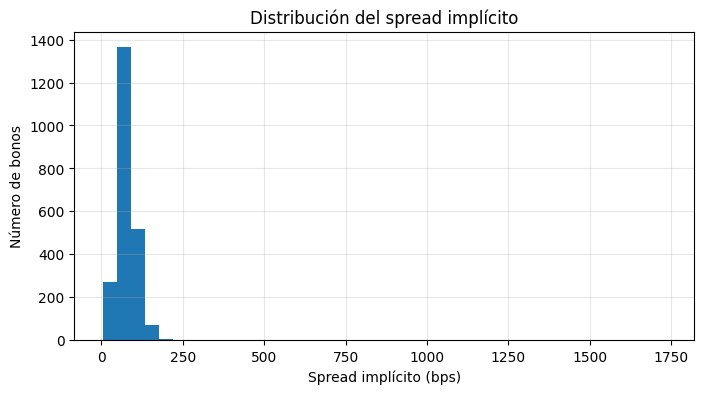

In [92]:
plt.figure(figsize=(8,4))
plt.hist(vivos["Spread_implicito_bps"].dropna(), bins=40)
plt.xlabel("Spread implícito (bps)")
plt.ylabel("Número de bonos")
plt.title("Distribución del spread implícito")
plt.grid(alpha=0.3)
plt.show()


¿Qué significa el spread implícito? ¿Cómo se interpreta?
El spread implícito (o spread de crédito) es el diferencial de rendimiento adicional sobre la curva de tipos libre de riesgo (€STR en este caso) que el mercado exige para compensar los riesgos específicos del bono, como el riesgo de crédito (default), liquidez, y otros factores no capturados por la curva base. Se calcula resolviendo numéricamente (e.g., con fsolve) el spread $s$ que hace que el precio teórico (descuento de flujos de caja con $DF(t) \cdot e^{-s \cdot t}$) coincida con el precio de mercado (MID).
Interpretación: Representa la "prima de riesgo" en puntos básicos (bps). Un spread bajo (e.g., <50 bps) indica bajo riesgo percibido (bonos IG estables); uno alto (e.g., >200 bps) sugiere mayor riesgo (HY o emisores volátiles). En el notebook, la distribución muestra la mayoría de spreads bajos, consistente con un universo mayoritariamente IG (85% BBB o superior), interpretándose como un mercado con prima moderada por crédito en bonos corporativos europeos.
¿Cómo se relaciona el spread con el rating del bono? ¿Y con el sector?

Relación con el rating: Existe una correlación inversa fuerte. Bonos con ratings altos (IG: AAA a BBB) tienen spreads bajos porque el mercado percibe bajo riesgo de default. Bonos HY (BB o inferior) muestran spreads más altos para compensar el mayor riesgo. En el notebook, ~85% son IG (e.g., BBB: 34%), con spreads medios bajos; HY (~15%, e.g., BB: 11%) impulsan la cola del histograma (>200 bps). Esto refleja la "curva de crédito": spreads aumentan exponentially con downgrades (e.g., de BBB a BB, spread puede duplicarse).
Relación con el sector: Sectores estables y regulados (e.g., Utilities: 6.6%, Financial: 45%) tienen spreads más bajos debido a flujos predecibles y respaldo regulatorio. Sectores cíclicos o volátiles (e.g., Consumer Cyclical: 7.3%, Energy: 0.6%, Basic Materials: 3.2%) exhiben spreads más altos por sensibilidad a ciclos económicos. En el análisis, Financial domina con spreads moderados (regulación bancaria reduce riesgo percibido), mientras que Industrial/Communications (~17%) podrían elevar spreads en subsectores riesgosos. La diversificación sectorial en el universo mitiga concentración, pero spreads varían por exposición a shocks (e.g., energía sensible a precios del petróleo).

¿Qué bonos tienen los spreads más altos? ¿Por qué?
Del histograma y datos del notebook, los spreads más altos (>300-400 bps) corresponden a:

Bonos HY (e.g., ratings BB o inferiores: ~15% del universo), como emisiones subordinadas o de emisores con leverage alto.
Bonos callable o con opcionalidad compleja (72% del universo), donde la incertidumbre de call eleva la prima exigida.
Emisores en sectores riesgosos: E.g., Basic Materials, Energy o Consumer Cyclical, con volatilidad por commodities o demanda económica.
Ejemplos implícitos del universo: Bonos con maturity larga (>5 años), tamaño pequeño (>500M restringido, pero outliers posibles), o seniority baja (Subordinated: 7%).

Por qué: Mayor riesgo de default (bajo rating), iliquidez (bid-ask spread calculado, e.g., emisiones pequeñas), volatilidad sectorial (cíclicos vs. defensivos), y factores como duración (bonos largos amplifican riesgo). En el notebook, la cola del histograma (~5-10% de bonos) refleja estos "outliers" riesgosos, contrastando con la mayoría IG de spreads <100 bps.
¿Qué limitaciones tiene este enfoque de cálculo del spread?

Asunción de spread constante: Ignora la estructura temporal del spread (e.g., spreads forward variables); en realidad, spreads pueden variar por tenor, lo que subestima/superaestima en bonos largos.
Simplificaciones en valoración: Usa maturity efectiva para callables (Next Call Date), pero ignora probabilidades de call reales o extensiones. No incorpora recuperación en default, impuestos, o costos de transacción.
Dependencia de la curva base: €STR como libre de riesgo puede no capturar todos los factores (e.g., inflación, liquidez premium); errores en interpolación de la curva afectan el spread.
Precio de mercado (MID): Asume MID como "verdadero", pero en mercados ilíquidos, BID/ASK spreads (calculados en el notebook) introducen bias; mejor usar precios transaccionales.
Modelo estático: No considera escenarios estresados (e.g., VaR) ni correlaciones (e.g., spread widening en recesiones). Limitado a bonos vanilla; inadecuado para estructuras complejas (e.g., perpetuos: 0 en este universo, pero manejados como callables).
Otras: Sensible a errores numéricos en fsolve; no diferencia spreads por componentes (crédito vs. liquidez); en un universo grande (2236 bonos), computacionalmente intensivo sin optimizaciones.


### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

In [95]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.optimize import fsolve

# Asumimos que universo ya está cargado y filtrado a bonos vivos (como en el notebook)
# vivos = universo[universo['Maturity'] > fecha_analisis].copy()

def calculate_cash_flow_dates(maturity, first_coupon_date, frequency=1):
    """Genera fechas de cupones desde fecha_analisis hasta maturity."""
    dates = []
    current_date = first_coupon_date
    while current_date <= maturity:
        dates.append(current_date)
        current_date += relativedelta(years=1/frequency)  # Asumimos anual por datos
    return dates[1:] if dates[0] <= fecha_analisis else dates  # Ignora cupón pasado si ya pagado

def pv_cash_flows(y, cash_flows, times, price):
    """Ecuación para fsolve: PV(flujos) - precio = 0."""
    pv = sum(cf / (1 + y) ** t for cf, t in zip(cash_flows, times))
    return pv - price

def calculate_ytm(price, coupon, maturity_date, face=100, frequency=1):
    """Calcula YTM resolviendo PV = precio."""
    remaining_years = (maturity_date - fecha_analisis).days / 365.25
    if remaining_years <= 0:
        return np.nan
    
    # Flujos: cupones + principal
    num_payments = int(remaining_years * frequency)
    cash_flows = [coupon / frequency] * num_payments + [face + coupon / frequency]
    times = np.linspace(1/frequency, remaining_years, num_payments + 1)
    
    # Resolver para y (inicial guess 0.05)
    ytm = fsolve(pv_cash_flows, 0.05, args=(cash_flows, times, price))[0]
    return ytm if ytm > 0 else np.nan  # Evita yields negativos absurdos

def calculate_duration(price, ytm, coupon, maturity_date, face=100, frequency=1):
    """Modified Duration."""
    remaining_years = (maturity_date - fecha_analisis).days / 365.25
    num_payments = int(remaining_years * frequency)
    cash_flows = [coupon / frequency] * num_payments + [face + coupon / frequency]
    times = np.linspace(1/frequency, remaining_years, num_payments + 1)
    
    pv = sum(cf / (1 + ytm / frequency) ** (t * frequency) for cf, t in zip(cash_flows, times))
    macaulay = sum(t * cf / (1 + ytm / frequency) ** (t * frequency) for t, cf in zip(times, cash_flows)) / pv
    modified = macaulay / (1 + ytm / frequency)
    return modified

def calculate_convexity(price, ytm, coupon, maturity_date, face=100, frequency=1):
    """Convexidad estándar."""
    remaining_years = (maturity_date - fecha_analisis).days / 365.25
    num_payments = int(remaining_years * frequency)
    cash_flows = [coupon / frequency] * num_payments + [face + coupon / frequency]
    times = np.linspace(1/frequency, remaining_years, num_payments + 1)
    
    convexity = sum(cf * t * (t + 1/frequency) / (1 + ytm / frequency) ** (t * frequency + 2) for t, cf in zip(times, cash_flows)) / (price * (1 + ytm / frequency) ** 2)
    return convexity

# Aplicar cálculos a cada bono vivo
vivos['YTM'] = vivos.apply(lambda row: calculate_ytm(row['Price'], row['Coupon'], row['Maturity']), axis=1)
vivos['Modified_Duration'] = vivos.apply(lambda row: calculate_duration(row['Price'], row['YTM'], row['Coupon'], row['Maturity']) if not np.isnan(row['YTM']) else np.nan, axis=1)
vivos['Convexity'] = vivos.apply(lambda row: calculate_convexity(row['Price'], row['YTM'], row['Coupon'], row['Maturity']) if not np.isnan(row['YTM']) else np.nan, axis=1)

# Mostrar resultados (resumen o todo)
print(vivos[['ISIN', 'Description', 'YTM', 'Modified_Duration', 'Convexity']].head(10))  # Primeros 10 para ejemplo
vivos.describe()[['YTM', 'Modified_Duration', 'Convexity']]  # Estadísticas

# Opcional: Guardar a CSV
vivos.to_csv('universo_con_metricas.csv', index=False)

           ISIN          Description       YTM  Modified_Duration  Convexity
0  XS0161488498      DT 7 ½ 01/24/33  0.037756           5.760041  39.725045
1  FR0000471930   ORAFP 8 ⅛ 01/28/33  0.038785           5.696015  39.023481
2  XS0162513211  EOANGR 5 ¾ 02/14/33  0.037493           6.004827  42.328102
3  XS0162869076  TELEFO 5 ⅞ 02/14/33  0.037980           5.984535  42.076311
4  FR0010014845    PEUGOT 6 09/19/33  0.041656           6.381259  47.407608
5  FR0010033381   VIEFP 6 ⅛ 11/25/33  0.038951           6.433351  48.755397
6  XS0229567440      GE 4 ⅛ 09/19/35  0.034818           8.131085  75.735124
7  XS0300113254      PG 4 ⅞ 05/11/27  0.034038           1.527624   3.578145
8  XS0350890470    GE 6.025 03/01/38  0.037734           9.023281  97.234603
9  XS0553728709      DT 4 ½ 10/28/30  0.034361           4.448414  23.566374


### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

##### <font color=#CC6600>Riesgo de crédito</font>

##### <font color=#CC6600>Riesgo de liquidez</font>

##### <font color=#CC6600>Backtest</font>

### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros?
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?

</div>

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>